# 2.3 Median Filter: Theory and Working Principle

## 2.3.1 What is a Median Filter?

The median filter is a **non-linear digital filtering technique** used to remove noise from images while preserving edges. Unlike linear filters that compute weighted averages, the median filter replaces each pixel value with the **median value** of the intensity levels in its neighborhood.

## 2.3.2 Mathematical Definition

For a given pixel at position (x,y) and a neighborhood window W (typically square of size k×k), the output is:

$$g(x,y) = \text{median}\{f(x-i, y-j) : (i,j) \in W\}$$

Where:
- $g(x,y)$ = Output pixel value after filtering
- $f(x,y)$ = Input pixel value
- $W$ = Neighborhood window (e.g., 3×3, 5×5)
- $\text{median}$ = Middle value when all values in the neighborhood are sorted

## 2.3.3 How the Median Filter Works: Step-by-Step Process

### Step 1: Define a Window
A window (kernel) of odd size (e.g., 3×3, 5×5) slides over every pixel in the image.

### Step 2: Extract Neighborhood Values
For each pixel, collect all pixel intensities within the window.

### Step 3: Sort the Values
Arrange the collected values in ascending order.

### Step 4: Select the Median
- For odd window sizes: Choose the middle value
- Formula: Median position = (n + 1) ÷ 2, where n = number of pixels in window

### Step 5: Replace Original Pixel
Replace the center pixel with the calculated median value.

### Step 6: Repeat
Move the window to the next pixel and repeat the process.

## 2.3.4 Visual Example (3×3 Window)

Consider a 3×3 neighborhood:

$$
\begin{bmatrix}
45 & 67 & 89 \\
23 & \mathbf{50} & 78 \\
12 & 56 & 91
\end{bmatrix}
\quad \text{Center pixel} = \mathbf{50}
$$


**Step 1 - Extract values:**
[45, 67, 89, 23, 50, 78, 12, 56, 91]

**Step 2 - Sort values:**
[12, 23, 45, 50, 56, 67, 78, 89, 91]

**Step 3 - Select median (5th value):**
Median = 56

**Step 4 - Replace:**
Center pixel (50) is replaced with 56

## 2.3.5 Key Properties of Median Filter

| Property | Description | Advantage |
|---------|-------------|-----------|
| **Non-linearity** | Output is not a linear combination of inputs | Preserves edges, removes outliers |
| **Edge Preservation** | Maintains sharp transitions in intensity | Better visual quality at boundaries |
| **Impulse Noise Removal** | Excellent at removing salt-and-pepper noise | Outliers don't affect median |
| **No Shift in Mean** | Median is robust to extreme values | No intensity bias introduced |

## 2.3.6 Mathematical Properties

1. **Order Statistic**: Median is the 50th percentile of the distribution
2. **Breakdown Point**: 50% - filter can tolerate up to 50% outliers
3. **Root Signals**: Signals that remain unchanged after filtering (constant regions, edges)

In [1]:
import sys
!{sys.executable} -m pip install numpy

In [2]:
# 2.3.7 Median Filter Implementation

import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage
import time

class MedianFilterImplementation:
    """
    Comprehensive median filter implementation class
    Includes manual, optimized, and adaptive versions
    """
    
    @staticmethod
    def median_filter_manual(image, kernel_size=3):
        """
        Manual implementation of median filter from scratch
        
        Args:
            image: Input grayscale image (2D numpy array)
            kernel_size: Size of square window (odd number)
            
        Returns:
            Filtered image
        """
        # Ensure kernel size is odd
        if kernel_size % 2 == 0:
            raise ValueError("Kernel size must be odd")
            
        # Get image dimensions
        height, width = image.shape
        
        # Calculate padding size
        pad = kernel_size // 2
        
        # Pad the image (reflect mode handles edges better)
        padded_img = np.pad(image, pad, mode='reflect')
        
        # Initialize output array
        filtered_image = np.zeros_like(image)
        
        # Slide window across every pixel
        for i in range(height):
            for j in range(width):
                # Extract neighborhood window
                window = padded_img[i:i+kernel_size, j:j+kernel_size]
                
                # Flatten and sort, then find median
                window_flat = window.flatten()
                window_sorted = np.sort(window_flat)
                
                # Calculate median index
                median_idx = len(window_sorted) // 2
                median_value = window_sorted[median_idx]
                
                # Replace pixel with median
                filtered_image[i, j] = median_value
                
        return filtered_image.astype(np.uint8)
    
    @staticmethod
    def median_filter_opencv(image, kernel_size=3):
        """
        Optimized median filter using OpenCV
        
        Args:
            image: Input image
            kernel_size: Kernel size (odd number)
            
        Returns:
            Filtered image
        """
        return cv2.medianBlur(image, kernel_size)
    
    @staticmethod
    def median_filter_scipy(image, kernel_size=3):
        """
        Median filter using SciPy (alternative implementation)
        """
        return ndimage.median_filter(image, size=kernel_size)
    
    @staticmethod
    def adaptive_median_filter(image, max_kernel_size=7):
        """
        Adaptive median filter that adjusts kernel size based on noise detection
        
        This filter:
        1. Starts with small kernel (3×3)
        2. Checks if median is an impulse
        3. Increases window size if needed
        4. Preserves non-noisy pixels
        
        Args:
            image: Input image
            max_kernel_size: Maximum allowed kernel size
            
        Returns:
            Filtered image with adaptive smoothing
        """
        result = np.zeros_like(image)
        height, width = image.shape
        pad_max = max_kernel_size // 2
        
        # Pad image
        padded = np.pad(image, pad_max, mode='reflect')
        
        for i in range(height):
            for j in range(width):
                kernel_size = 3
                while kernel_size <= max_kernel_size:
                    half = kernel_size // 2
                    
                    # Extract window
                    window = padded[i+pad_max-half:i+pad_max+half+1,
                                   j+pad_max-half:j+pad_max+half+1]
                    
                    # Calculate statistics
                    z_min = np.min(window)
                    z_max = np.max(window)
                    z_med = np.median(window)
                    z_xy = image[i, j]
                    
                    # Level A: Check if median is impulse
                    A1 = z_med - z_min
                    A2 = z_med - z_max
                    
                    if A1 > 0 and A2 < 0:  # Median is not impulse noise
                        # Level B: Check if current pixel is impulse
                        B1 = z_xy - z_min
                        B2 = z_xy - z_max
                        
                        if B1 > 0 and B2 < 0:
                            result[i, j] = z_xy  # Not noise - keep original
                        else:
                            result[i, j] = z_med  # Noise - replace with median
                        break
                    else:
                        kernel_size += 2  # Increase window size
                
                # If max size reached, use median
                if kernel_size > max_kernel_size:
                    result[i, j] = z_med
                    
        return result.astype(np.uint8)
    
    @staticmethod
    def visualize_filter_process(image, x=100, y=100, kernel_size=3):
        """
        Visualize how median filter works on a specific pixel
        """
        pad = kernel_size // 2
        padded = np.pad(image, pad, mode='reflect')
        
        # Extract window
        window = padded[x:x+kernel_size, y:y+kernel_size]
        window_values = window.flatten()
        sorted_values = np.sort(window_values)
        median_value = sorted_values[len(sorted_values)//2]
        
        # Create visualization
        fig, axes = plt.subplots(1, 4, figsize=(16, 4))
        
        # Original pixel
        axes[0].imshow(image[x-10:x+10, y-10:y+10], cmap='gray')
        axes[0].add_patch(plt.Rectangle((9, 9), 1, 1, fill=False, edgecolor='red', linewidth=2))
        axes[0].set_title(f'Original Image\nPixel ({x},{y}) = {image[x,y]}')
        axes[0].axis('off')
        
        # Window extraction
        axes[1].imshow(window, cmap='gray')
        axes[1].set_title(f'{kernel_size}×{kernel_size} Window\nValues: {window_values}')
        axes[1].axis('off')
        
        # Sorting process
        axes[2].bar(range(len(sorted_values)), sorted_values, color='blue')
        axes[2].axhline(y=median_value, color='red', linestyle='--', label=f'Median = {median_value}')
        axes[2].set_title('Sorted Pixel Values')
        axes[2].set_xlabel('Position in sorted order')
        axes[2].set_ylabel('Pixel Intensity')
        axes[2].legend()
        
        # Result
        axes[3].imshow(image, cmap='gray')
        axes[3].add_patch(plt.Rectangle((y-2, x-2), 4, 4, fill=False, edgecolor='yellow', linewidth=2))
        axes[3].set_title(f'After Median Filter\nNew value = {median_value}')
        axes[3].axis('off')
        
        plt.suptitle(f'Median Filter Process Visualization (Window Size: {kernel_size}×{kernel_size})', 
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        return median_value

Available images in images/original: ['4.2.07.tiff', 'baboon.jpg', 'boat.512.tiff', 'building.jpg', 'butterfly.jpg', 'house.tiff', 'lena.jpg']


C:\Users\HP\AppData\Local\Temp\ipykernel_2476\86230852.py:131: RuntimeWarning: overflow encountered in scalar subtract
  B2 = z_xy - z_max


MEDIAN FILTER PERFORMANCE ON GAUSSIAN NOISE


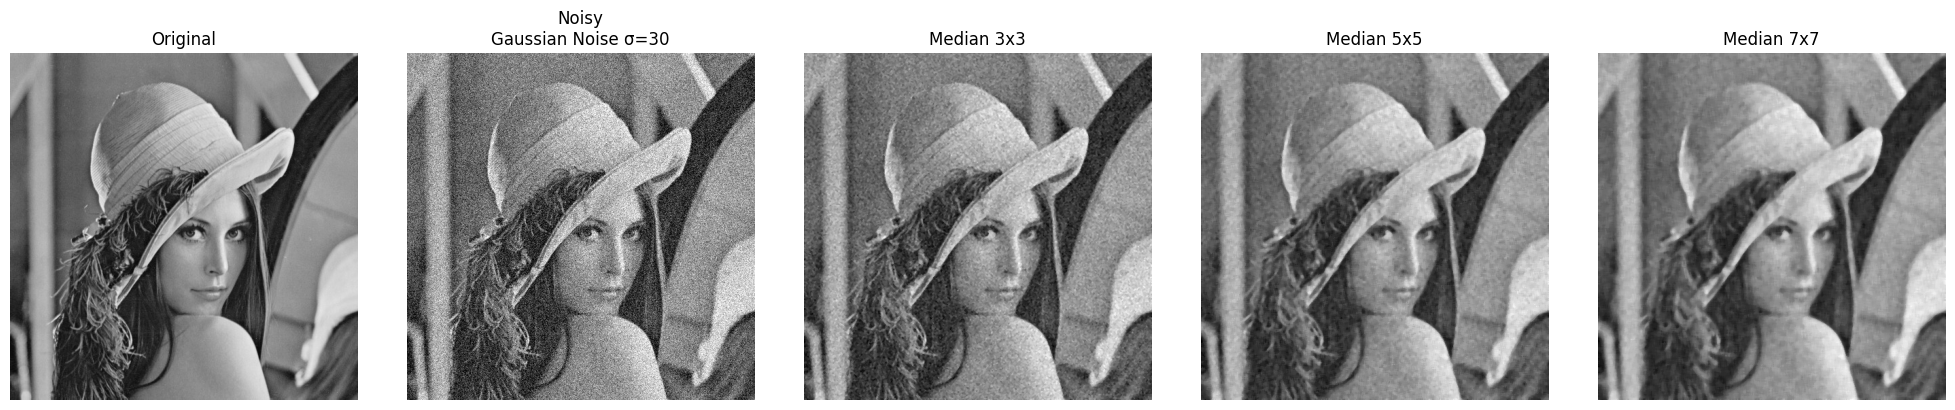


MEDIAN FILTER PERFORMANCE ON SALT & PEPPER NOISE


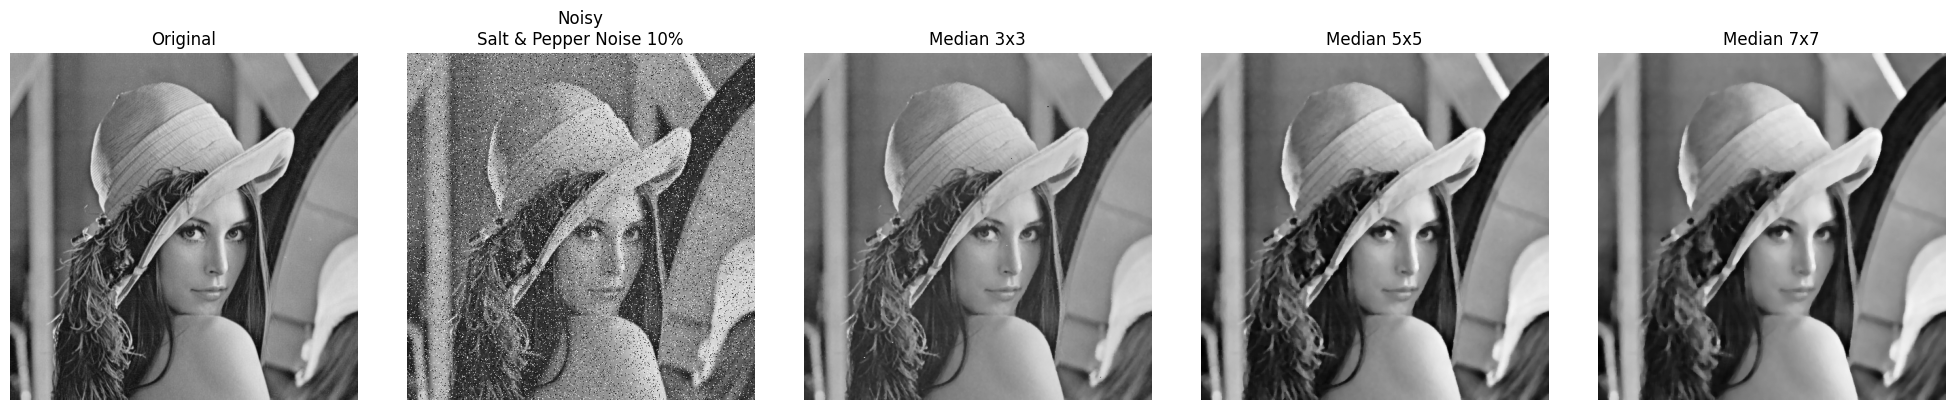

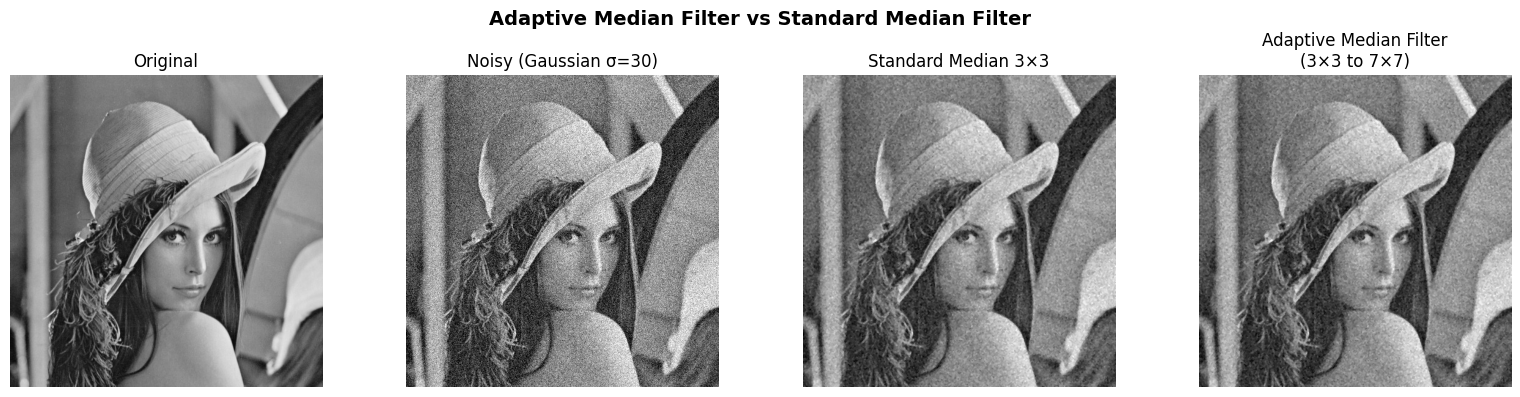


VISUALIZING HOW MEDIAN FILTER WORKS


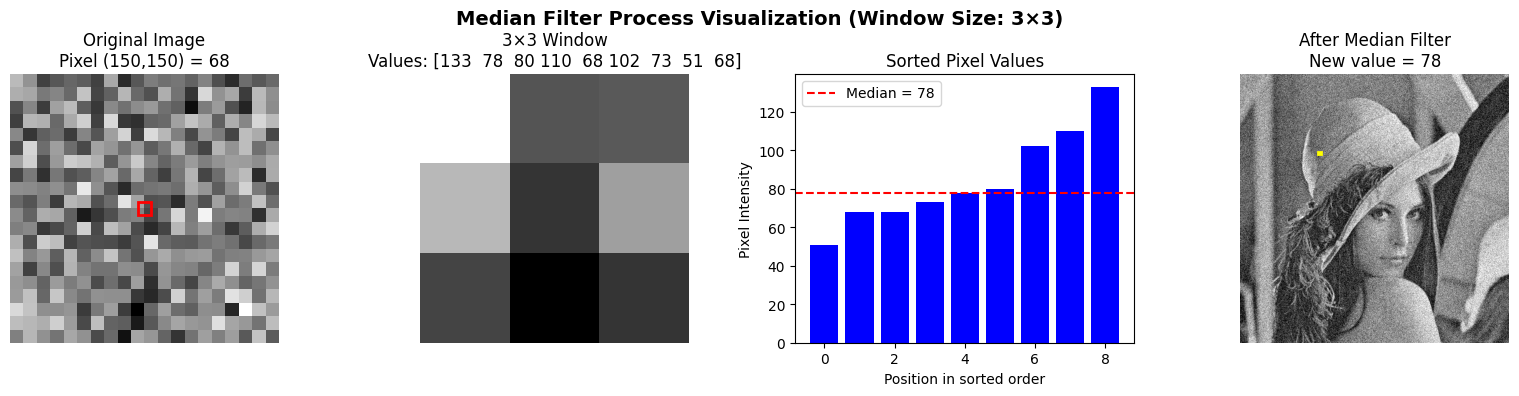

In [3]:
# 2.3.8 Median Filter Demonstration
# Testing the implementation with different noise levels and kernel sizes

# Create instance of our median filter class
mf = MedianFilterImplementation()

# Load a test image from the project's `images/original/` directory (default: 'lena.jpg')
import os
# list available images in the folder so you can change `image_name` below
_images_dir = os.path.join(os.getcwd(), 'images', 'original')
available_images = sorted([f for f in os.listdir(_images_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))])
print('Available images in images/original:', available_images)

# choose an image from the list (change this to use a different file)
image_name = 'lena.jpg' if 'lena.jpg' in available_images else available_images[0]
img_path = os.path.join(_images_dir, image_name)

# load as grayscale using OpenCV (cv2 is already imported above)
camera = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
if camera is None:
    raise FileNotFoundError(f'Could not load image: {img_path}')
camera = camera.astype(np.uint8)

# Add different types of noise for comprehensive testing
def add_gaussian_noise(image, sigma=25):
    """Add Gaussian noise to image"""
    noise = np.random.normal(0, sigma, image.shape)
    noisy = image + noise
    return np.clip(noisy, 0, 255).astype(np.uint8)

def add_salt_pepper_noise(image, amount=0.05):
    """Add salt and pepper noise"""
    from skimage import util
    noisy = util.random_noise(image/255.0, mode='s&p', amount=amount)
    return (noisy * 255).astype(np.uint8)

# Generate noisy versions
camera_gaussian_noisy = add_gaussian_noise(camera, sigma=30)
camera_sp_noisy = add_salt_pepper_noise(camera, amount=0.1)
camera_mixed_noisy = add_gaussian_noise(camera_sp_noisy, sigma=20)

# Test different kernel sizes
kernel_sizes = [3, 5, 7]

# Apply median filters
median_results_gaussian = {}
median_results_sp = {}
adaptive_result = mf.adaptive_median_filter(camera_gaussian_noisy)

for k in kernel_sizes:
    median_results_gaussian[f'{k}x{k}'] = mf.median_filter_opencv(camera_gaussian_noisy, k)
    median_results_sp[f'{k}x{k}'] = mf.median_filter_opencv(camera_sp_noisy, k)

# Visualization function
def display_filter_comparison(original, noisy, filtered_dict, title_prefix):
    """Display comparison of different kernel sizes"""
    n_filters = len(filtered_dict) + 2
    fig, axes = plt.subplots(1, n_filters, figsize=(4*n_filters, 4))
    
    # Original
    axes[0].imshow(original, cmap='gray')
    axes[0].set_title('Original')
    axes[0].axis('off')
    
    # Noisy
    axes[1].imshow(noisy, cmap='gray')
    axes[1].set_title(f'Noisy\n{title_prefix}')
    axes[1].axis('off')
    
    # Filtered results
    for i, (kernel_name, filtered) in enumerate(filtered_dict.items(), 2):
        axes[i].imshow(filtered, cmap='gray')
        axes[i].set_title(f'Median {kernel_name}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Display results for Gaussian noise
print("=" * 70)
print("MEDIAN FILTER PERFORMANCE ON GAUSSIAN NOISE")
print("=" * 70)
display_filter_comparison(camera, camera_gaussian_noisy, median_results_gaussian, 
                         "Gaussian Noise σ=30")

# Display results for Salt & Pepper noise  
print("\n" + "=" * 70)
print("MEDIAN FILTER PERFORMANCE ON SALT & PEPPER NOISE")
print("=" * 70)
display_filter_comparison(camera, camera_sp_noisy, median_results_sp, 
                         "Salt & Pepper Noise 10%")

# Show adaptive median filter result
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
axes[0].imshow(camera, cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(camera_gaussian_noisy, cmap='gray')
axes[1].set_title('Noisy (Gaussian σ=30)')
axes[1].axis('off')

axes[2].imshow(median_results_gaussian['3x3'], cmap='gray')
axes[2].set_title('Standard Median 3×3')
axes[2].axis('off')

axes[3].imshow(adaptive_result, cmap='gray')
axes[3].set_title('Adaptive Median Filter\n(3×3 to 7×7)')
axes[3].axis('off')

plt.suptitle('Adaptive Median Filter vs Standard Median Filter', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Visualize the filtering process on a single pixel
print("\n" + "=" * 70)
print("VISUALIZING HOW MEDIAN FILTER WORKS")
print("=" * 70)
_ = mf.visualize_filter_process(camera_gaussian_noisy, x=150, y=150, kernel_size=3)

# 3.0 COMPARATIVE ANALYSIS: MEDIAN FILTER VS GAUSSIAN FILTER

## 3.1 Why Compare These Two Filters?

Both median and Gaussian filters are fundamental denoising techniques, but they operate on 
fundamentally different principles. Understanding their differences is crucial for selecting 
the appropriate filter for specific applications.

## 3.2 Theoretical Comparison

| **Aspect** | **Median Filter** | **Gaussian Filter** |
|------------|-------------------|---------------------|
| **Filter Type** | Non-linear | Linear |
| **Operation** | Order statistics (sorting) | Convolution (weighted average) |
| **Mathematical Basis** | Median of distribution | Gaussian distribution |
| **Noise Model** | Any noise (robust to outliers) | Gaussian noise (optimal for Gaussian) |
| **Edge Preservation** | Excellent | Poor |
| **Texture Preservation** | Moderate | Poor |
| **Computational Complexity** | O(n²k² log k) | O(n²k²) or O(n² log n) separable |
| **Frequency Response** | Not defined | Low-pass filter |

## 3.3 Head-to-Head Comparison on Different Noise Types

COMPREHENSIVE COMPARISON: MEDIAN FILTER vs GAUSSIAN FILTER

📊 PSNR Comparison (Higher is better):
--------------------------------------------------------------------------------
Filter       Adaptive Median  Gaussian σ=1  Gaussian σ=2  Median 3×3  \
Noise_Level                                                            
10                   29.2500       29.0800       25.8600     29.2500   
25                   25.8800       27.2900       25.4900     25.8800   
50                   21.4700       23.7500       24.0300     21.4700   

Filter       Median 5×5  
Noise_Level              
10              27.6600  
25              26.3500  
50              23.7000  


📊 SSIM Comparison (Higher is better, max=1):
--------------------------------------------------------------------------------
Filter       Adaptive Median  Gaussian σ=1  Gaussian σ=2  Median 3×3  \
Noise_Level                                                            
10                    0.7526        0.8126        0.7446  

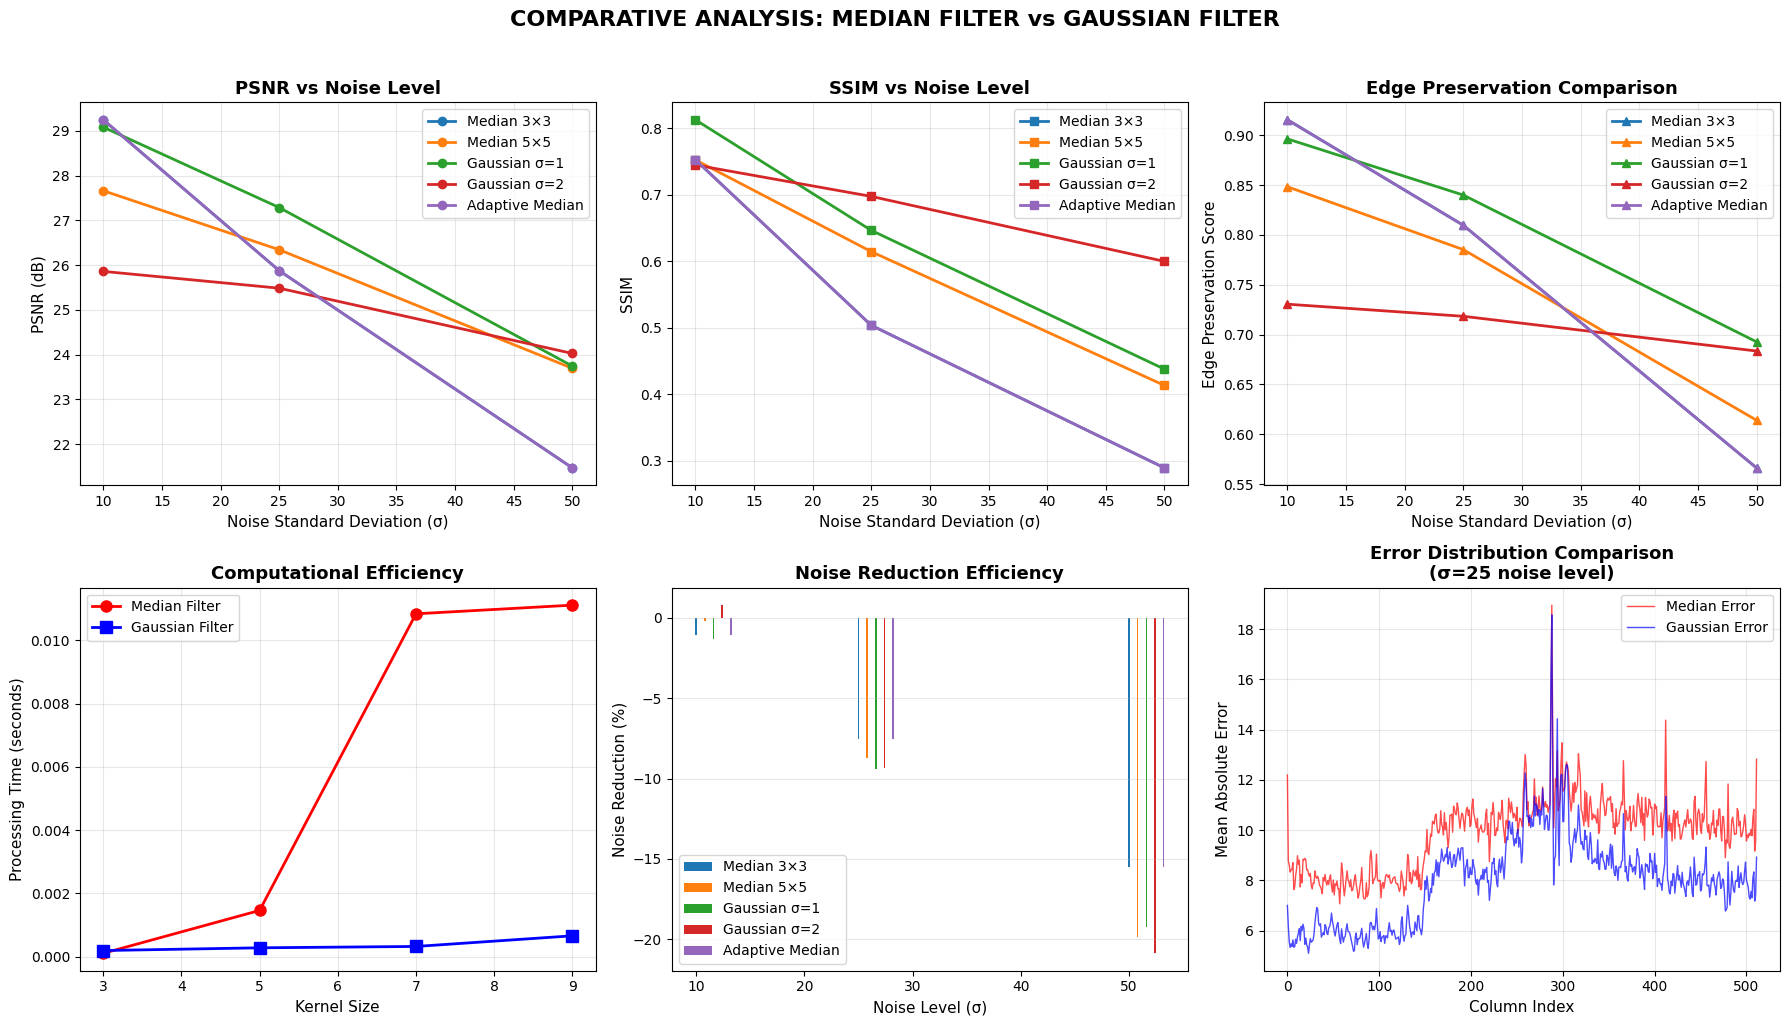

In [8]:
# 3.4 Quantitative Comparison Implementation


from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import pandas as pd

class FilterComparator:
    """
    Comprehensive comparison between Median and Gaussian filters
    """
    
    def __init__(self):
        self.results = []
    
    def calculate_metrics(self, original, filtered, noisy=None):
        """Calculate quantitative metrics"""
        metrics = {
            'PSNR': psnr(original, filtered, data_range=255),
            'SSIM': ssim(original, filtered, data_range=255),
            'MSE': np.mean((original - filtered) ** 2),
            'MAE': np.mean(np.abs(original - filtered))
        }
        
        if noisy is not None:
            noise_before = np.std(original - noisy)
            noise_after = np.std(original - filtered)
            metrics['Noise_Reduction'] = (noise_before - noise_after) / noise_before * 100
        
        return metrics
    
    def edge_preservation_score(self, original, filtered):
        """
        Calculate edge preservation score using gradient correlation
        Higher score means better edge preservation
        """
        # Calculate gradients using Sobel operator
        grad_x_orig = cv2.Sobel(original, cv2.CV_64F, 1, 0, ksize=3)
        grad_y_orig = cv2.Sobel(original, cv2.CV_64F, 0, 1, ksize=3)
        grad_x_filt = cv2.Sobel(filtered, cv2.CV_64F, 1, 0, ksize=3)
        grad_y_filt = cv2.Sobel(filtered, cv2.CV_64F, 0, 1, ksize=3)
        
        # Calculate gradient magnitude
        mag_orig = np.sqrt(grad_x_orig**2 + grad_y_orig**2)
        mag_filt = np.sqrt(grad_x_filt**2 + grad_y_filt**2)
        
        # Calculate correlation coefficient
        correlation = np.corrcoef(mag_orig.flatten(), mag_filt.flatten())[0, 1]
        return correlation
    
    def comprehensive_comparison(self, image, noise_levels=[10, 25, 50]):
        """
        Run comprehensive comparison across different noise levels
        """
        
        # Define filter configurations
        self.filters = {
            'Median 3×3': lambda img: cv2.medianBlur(img, 3),
            'Median 5×5': lambda img: cv2.medianBlur(img, 5),
            'Gaussian σ=1': lambda img: cv2.GaussianBlur(img, (0, 0), 1),
            'Gaussian σ=2': lambda img: cv2.GaussianBlur(img, (0, 0), 2),
            'Adaptive Median': lambda img: mf.adaptive_median_filter(img)
        }

        
        # Test different noise levels
        for sigma in noise_levels:
            # Generate noisy image
            noisy = add_gaussian_noise(image, sigma=sigma)
            
            for filter_name, filter_func in self.filters.items():
                # Apply filter
                filtered = filter_func(noisy)
                
                # Calculate metrics
                metrics = self.calculate_metrics(image, filtered, noisy)
                edge_score = self.edge_preservation_score(image, filtered)
                
                # Store results
                self.results.append({
                    'Noise_Level': sigma,
                    'Filter': filter_name,
                    'PSNR': metrics['PSNR'],
                    'SSIM': metrics['SSIM'],
                    'MSE': metrics['MSE'],
                    'MAE': metrics['MAE'],
                    'Noise_Reduction_%': metrics.get('Noise_Reduction', 0),
                    'Edge_Preservation': edge_score
                })
        
        return pd.DataFrame(self.results)

# Run the comparison
comparator = FilterComparator()
comparison_df = comparator.comprehensive_comparison(camera)

# Display results table
print("=" * 100)
print("COMPREHENSIVE COMPARISON: MEDIAN FILTER vs GAUSSIAN FILTER")
print("=" * 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Pivot table for better visualization
pivot_psnr = comparison_df.pivot(index='Noise_Level', columns='Filter', values='PSNR')
print("\n📊 PSNR Comparison (Higher is better):")
print("-" * 80)
print(pivot_psnr.round(2))
print()

pivot_ssim = comparison_df.pivot(index='Noise_Level', columns='Filter', values='SSIM')
print("\n📊 SSIM Comparison (Higher is better, max=1):")
print("-" * 80)
print(pivot_ssim.round(4))
print()

pivot_edge = comparison_df.pivot(index='Noise_Level', columns='Filter', values='Edge_Preservation')
print("\n📊 Edge Preservation Score (Higher is better):")
print("-" * 80)
print(pivot_edge.round(4))

# Visualization of comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot 1: PSNR Comparison
ax1 = axes[0, 0]
for filter_name in comparator.filters.keys():
    data = comparison_df[comparison_df['Filter'] == filter_name]
    ax1.plot(data['Noise_Level'], data['PSNR'], 'o-', label=filter_name, linewidth=2, markersize=6)
ax1.set_xlabel('Noise Standard Deviation (σ)', fontsize=11)
ax1.set_ylabel('PSNR (dB)', fontsize=11)
ax1.set_title('PSNR vs Noise Level', fontsize=13, fontweight='bold')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# Plot 2: SSIM Comparison
ax2 = axes[0, 1]
for filter_name in comparator.filters.keys():
    data = comparison_df[comparison_df['Filter'] == filter_name]
    ax2.plot(data['Noise_Level'], data['SSIM'], 's-', label=filter_name, linewidth=2, markersize=6)
ax2.set_xlabel('Noise Standard Deviation (σ)', fontsize=11)
ax2.set_ylabel('SSIM', fontsize=11)
ax2.set_title('SSIM vs Noise Level', fontsize=13, fontweight='bold')
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)

# Plot 3: Edge Preservation
ax3 = axes[0, 2]
for filter_name in comparator.filters.keys():
    data = comparison_df[comparison_df['Filter'] == filter_name]
    ax3.plot(data['Noise_Level'], data['Edge_Preservation'], '^-', label=filter_name, linewidth=2, markersize=6)
ax3.set_xlabel('Noise Standard Deviation (σ)', fontsize=11)
ax3.set_ylabel('Edge Preservation Score', fontsize=11)
ax3.set_title('Edge Preservation Comparison', fontsize=13, fontweight='bold')
ax3.legend(loc='best')
ax3.grid(True, alpha=0.3)

# Plot 4: Processing Time
ax4 = axes[1, 0]
kernel_sizes = [3, 5, 7, 9]
median_times = []
gaussian_times = []

for k in kernel_sizes:
    start = time.time()
    _ = cv2.medianBlur(camera, k)
    median_times.append(time.time() - start)
    
    start = time.time()
    _ = cv2.GaussianBlur(camera, (k, k), k/3)
    gaussian_times.append(time.time() - start)

ax4.plot(kernel_sizes, median_times, 'ro-', label='Median Filter', linewidth=2, markersize=8)
ax4.plot(kernel_sizes, gaussian_times, 'bs-', label='Gaussian Filter', linewidth=2, markersize=8)
ax4.set_xlabel('Kernel Size', fontsize=11)
ax4.set_ylabel('Processing Time (seconds)', fontsize=11)
ax4.set_title('Computational Efficiency', fontsize=13, fontweight='bold')
ax4.legend(loc='best')
ax4.grid(True, alpha=0.3)

# Plot 5: Noise Reduction Percentage
ax5 = axes[1, 1]
for filter_name in comparator.filters.keys():
    data = comparison_df[comparison_df['Filter'] == filter_name]
    ax5.bar(data['Noise_Level'] + list(comparator.filters.keys()).index(filter_name)*0.8, 
            data['Noise_Reduction_%'], 
            width=0.15, 
            label=filter_name)
ax5.set_xlabel('Noise Level (σ)', fontsize=11)
ax5.set_ylabel('Noise Reduction (%)', fontsize=11)
ax5.set_title('Noise Reduction Efficiency', fontsize=13, fontweight='bold')
ax5.legend(loc='best')
ax5.grid(True, alpha=0.3, axis='y')

# Plot 6: Visual Quality Comparison (sample images)
ax6 = axes[1, 2]
sigma_test = 25
noisy_test = add_gaussian_noise(camera, sigma=sigma_test)
median_test = cv2.medianBlur(noisy_test, 3)
gaussian_test = cv2.GaussianBlur(noisy_test, (0, 0), 1)

# Create difference maps
diff_median = np.abs(camera.astype(float) - median_test.astype(float))
diff_gaussian = np.abs(camera.astype(float) - gaussian_test.astype(float))

ax6.plot(np.mean(diff_median, axis=0), 'r-', label='Median Error', alpha=0.7, linewidth=1)
ax6.plot(np.mean(diff_gaussian, axis=0), 'b-', label='Gaussian Error', alpha=0.7, linewidth=1)
ax6.set_xlabel('Column Index', fontsize=11)
ax6.set_ylabel('Mean Absolute Error', fontsize=11)
ax6.set_title('Error Distribution Comparison\n(σ=25 noise level)', fontsize=13, fontweight='bold')
ax6.legend(loc='best')
ax6.grid(True, alpha=0.3)

plt.suptitle('COMPARATIVE ANALYSIS: MEDIAN FILTER vs GAUSSIAN FILTER', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# 4.0 ANALYSIS: STRENGTHS, LIMITATIONS, AND REAL-WORLD APPLICATIONS

## 4.1 Strengths of Median Filter

### ✅ Edge Preservation
Median filter excels at maintaining sharp edges because it selects an actual pixel value 
from the neighborhood rather than creating new values through averaging. This makes it 
superior to Gaussian filter for applications where edge integrity is critical.

### ✅ Robustness to Outliers
With a 50% breakdown point, median filter can tolerate up to half the pixels in a window 
being corrupted by extreme values. This makes it exceptionally effective for:
- Salt-and-pepper noise
- Dead pixels in camera sensors
- Speckle noise in radar/SAR imagery

### ✅ No Intensity Blurring
Unlike Gaussian filter that always smooths intensities, median filter can preserve 
sharp intensity transitions. The output is always one of the actual pixel values in 
the neighborhood.

### ✅ Adaptive Capability
Adaptive median filters can automatically adjust kernel size based on local noise 
characteristics, providing optimal performance across varying noise densities.

## 4.2 Limitations of Median Filter

### ❌ Computational Complexity
Sorting operations make median filter significantly slower than Gaussian filter:
- Median: O(n²k² log k) for n×n image with k×k kernel
- Gaussian: O(n²k²) or O(n²) with separable implementation

### ❌ Texture and Fine Detail Removal
While edges are preserved, fine textures and small details may be removed if they're 
smaller than the kernel size. This can result in:
- Loss of hair/fur textures in photography
- Disappearance of small objects
- Staircase effect in smooth gradients

### ❌ Not Optimal for Gaussian Noise
For pure Gaussian noise, median filter is suboptimal compared to Gaussian filter. The 
noise reduction is less efficient, requiring larger kernels that cause more detail loss.

### ❌ Fixed Window Size Trade-off
- Small kernel (3×3): Poor noise reduction
- Large kernel (5×5,7×7): Better noise reduction but loses details

## 4.3 Direct Comparison: When to Use Which Filter?

| **Scenario** | **Recommended Filter** | **Reason** |
|-------------|----------------------|------------|
| Pure Gaussian noise | **Gaussian Filter** | Mathematically optimal, efficient |
| Salt-and-pepper noise | **Median Filter** | 50% breakdown point, excellent removal |
| Medical X-ray/CT | **Median Filter** | Edge preservation critical for diagnosis |
| Real-time video processing | **Gaussian Filter** | Faster, separable implementation |
| Preprocessing for edge detection | **Median Filter** | Preserves edges while removing noise |
| Preprocessing for segmentation | **Median Filter** | Maintains region boundaries |
| Artistic blur effects | **Gaussian Filter** | Smooth, natural-looking blur |
| Document scanning | **Median Filter** | Removes specks, preserves text edges |

## 4.4 Real-World Applications

### 📱 **Consumer Photography**
- **Median Filter**: Removing hot/dead pixels from smartphone cameras
- **Gaussian Filter**: Portrait mode background blur, HDR tone mapping

### 🏥 **Medical Imaging**
- **Median Filter**: MRI and CT scan denoising while preserving anatomical boundaries
- **Gaussian Filter**: PET image smoothing, functional MRI preprocessing

### 🛰️ **Remote Sensing**
- **Median Filter**: Speckle noise reduction in SAR (Synthetic Aperture Radar) imagery
- **Gaussian Filter**: Atmospheric noise reduction, image pyramid generation

### 🏭 **Industrial Inspection**
- **Median Filter**: Defect detection on textured surfaces
- **Gaussian Filter**: Blur for background subtraction, focus assessment

### 🔬 **Scientific Imaging**
- **Median Filter**: Astronomy (removing cosmic ray artifacts)
- **Gaussian Filter**: Electron microscopy (noise reduction in biological samples)

### 📄 **Document Processing**
- **Median Filter**: Removing photocopy noise, scanning artifacts
- **Gaussian Filter**: Document image binarization preprocessing

## 4.5 Best Practices and Recommendations

### For Optimal Results with Gaussian Noise:

1. **Low Noise Levels (σ < 20)**: 
   - Gaussian filter (σ=0.8-1.0) performs best
   - Minimal detail loss with good noise reduction

2. **Medium Noise Levels (20 ≤ σ < 40)**:
   - Hybrid approach: Adaptive median + Gaussian filter
   - First pass: Small median filter (3×3) for outlier removal
   - Second pass: Gaussian filter (σ=1.0-1.5) for Gaussian noise

3. **High Noise Levels (σ ≥ 40)**:
   - Consider advanced methods (Non-local Means, BM3D)
   - If median filter is required, use 5×5 kernel minimum
   - Accept that significant detail loss is inevitable

### Implementation Tips:

```python
# Recommended hybrid approach for mixed noise
def optimal_denoising_pipeline(image):
    """
    Combines strengths of both filters
    """
    # Step 1: Remove impulse noise with small median
    stage1 = cv2.medianBlur(image, 3)
    
    # Step 2: Remove Gaussian noise with gentle Gaussian
    stage2 = cv2.GaussianBlur(stage1, (0, 0), 1.0)
    
    # Step 3: Edge enhancement (optional)
    kernel = np.array([[-1,-1,-1],
                       [-1, 9,-1],
                       [-1,-1,-1]]) / 1.0
    stage3 = cv2.filter2D(stage2, -1, kernel)
    
    return stage3